<a href="https://colab.research.google.com/github/pletalk/EMPV-RPI-AutoDriving/blob/master/04-DeepPiCar-OpenCV-AutoLaneFoloow-Colab/LaneDetection_openCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라즈베리파이기반 차선 인식(Lane Detect)
@2020-08-01/@pletalk

본 주피터노트북을 수행하기 위해서 GPU/TPU설정은 하지 않아도 됩니다.


* 문서이력
    * 2020-08-01 코드 재수행 및 오류 점검
    * 2020-05-19 처음작성


* [참고자료]
    * [DeepPiCar — Part 4: Autonomous Lane Navigation via OpenCV](https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110)

## [1] DeepPiCar Git코드 다운로드
* 기본 다운로드 디렉토리는 /content/DeepPiCar 디렉토리에 저장

In [1]:
! git clone https://github.com/dctian/DeepPiCar.git

Cloning into 'DeepPiCar'...
remote: Enumerating objects: 1027, done.
remote: Total 1027 (delta 0), reused 0 (delta 0), pack-reused 1027
Receiving objects: 100% (1027/1027), 141.14 MiB | 33.79 MiB/s, done.
Resolving deltas: 100% (320/320), done.


In [2]:
! pwd
! cd DeepPiCar
! pwd

/content
/content


## [2] 라이브러리 로딩하기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

## [3] OpenCV기반 주행선탐지를 위한 이미지 전처리
* 원래 이미지를 출력(BGR -> RGB로 변환필요)
* hsv이미지를 출력 (BGR -> HSV로 변환필요)

### 1> 이미지 로딩하기

In [4]:
frame = cv2.imread('/content/DeepPiCar/driver/data/road1_240x320.png')

### 2> 원본 이미지 출력(BGR->RGB변환출력)

In [5]:
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

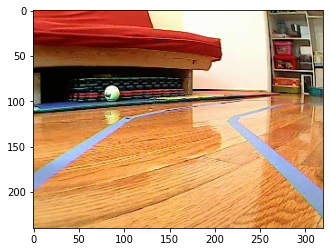

In [6]:
plt.imshow(rgb_frame)

### 3> HSV 이미지 출력(BGR -> HSW변환출력)

In [7]:
hsv_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

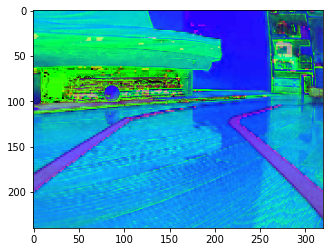

In [8]:
plt.imshow(hsv_image)

### 4> 이미지에서 주행선에 해당되는 라인선 값 설정하기

In [9]:
# 위에서 보라색으로 표시되는 주행선을 탐지하기 위해서 hsv기준으로 하한값과 상한값을 설정
lower_blue = np.array([30, 40, 0])
upper_blue = np.array([150, 255, 255])

# 하한값과 상한값 사이의 픽셀에는 255, 나머지는 0으로 설정
mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

In [10]:
# mask행렬의 크기
mask.shape

(240, 320)

In [11]:
#mask의 최대값, 최소값
np.max(mask),np.min(mask)

(255, 0)

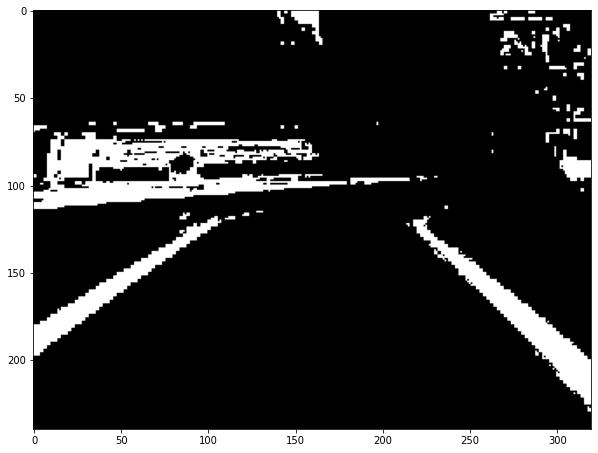

In [12]:
plt.figure(figsize=(10,8))
_ = plt.imshow(mask,cmap="gray")

## [4] Edge탐지하기

### 1> Canny Algorithm을 사용한 Edge탐지하기

In [16]:
# 이미지의 크기를 확인
mask.shape

(240, 320)

In [17]:
# canny함수의 2번째와 3번째는 픽셀에서의 edge grident의 범위를 설정
# 2개 사이의 값만 edge로 인식 (edge=255, 범위 밖의값은=0/black)
edges = cv2.Canny(mask, 200, 400)

In [18]:
# edges행렬의 최소/최대값
np.min(edges),np.max(edges)

(0, 255)

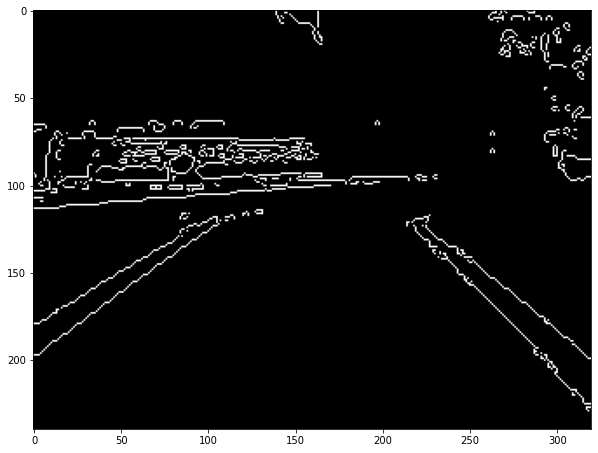

In [ ]:
plt.figure(figsize=(10,8))
_ = plt.imshow(edges,cmap="gray")

## [5] ROI(Region of Interests) 분리하기
* 주행선을 촬영한 이미지를 기준으로 Y축기준으로 이미지의 상단 부분은 주행선이 아닌 주변 사물들이 탐지
* 이러한 부분들은 주행선과 무관하기 때문에 해당 영역을 배제
* (0,0)에서 이미지의 높이의 1/2까지인 (120,320)까지는 black값으로 매스킹

### 1> 이미지 크기의 상단 1/2(높이기준)은 블랙(255)값으로 채운 마스크 생성하기

In [19]:
# 원래 이미지의 크기와 동일한 크기의 행렬을 만듬
height,width = edges.shape
bg_mask = np.zeros_like(edges)

In [20]:
# bg_mask값이 모두 블랙인지 확인
bg_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
# bg_mask의 최대값을 확인 (255가 아니면, 에러발생)
assert np.max(bg_mask) != 255

### 2> 아래 하단의 영역을 정상적인 값으로 채우기 위해서 도형 만들기

In [22]:
# 다각형의 좌표값만을 설정(여기서는 4개 사용해서 4각형도형)
# np.array에서 값의 type도 설정(np.int32)
polygon = np.array([[
        (0, height * 1 / 2),
        (width, height * 1 / 2),
        (width, height),
        (0, height),
    ]], np.int32)

In [24]:
# mask에서 Polygon영역을 255로 채우기
cv2.fillPoly(bg_mask, polygon, 255)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

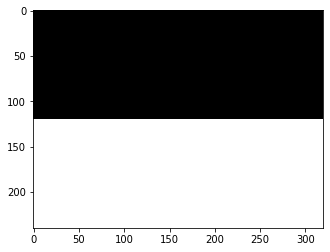

In [25]:
plt.imshow(bg_mask,cmap='gray')
#plt.axis('off')

### 3> edges이미지에서 하단의 1/2영역(높이기준)을 유지하기 위해서 mask와 bit연산수행

In [26]:
# bitwise_and 연산으로 mask값으로 255를 가진 edges의 영역만 제대로 표시
# 나머지, edges의 상단영역은 black픽셀값으로 표시
cropped_edges = cv2.bitwise_and(edges, bg_mask)

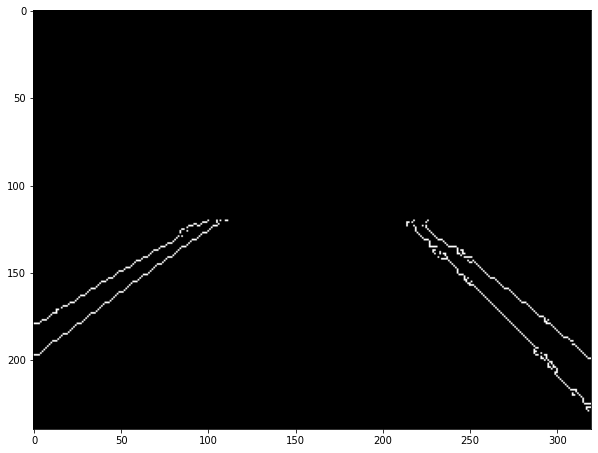

In [27]:
plt.figure(figsize=(10,8))
_ = plt.imshow(cropped_edges,cmap='gray')

## [6] 라인분할영역 탐지(Detect Line Segment)
* Canny Edge Detection으로부터 직선의 라인 만들기
* 허프변환(Hough Line Transform)을 사용 - openCV 제공
    * 

In [28]:
rho = 1  # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold = 10  # minimal of votes

In [29]:
# 3.14/180 (원주율을 180으로 나눔)
angle

0.017453292519943295

### 1> 허프변환을 수행

In [30]:
line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                minLineLength=8, maxLineGap=4)

#line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
#                                    np.array([]), minLineLength=8, maxLineGap=4)

#lines = cv2.HoughLinesP(E,rho = 1,theta = 1*np.pi/180,threshold = 100,minLineLength = 100,maxLineGap = 50)



In [31]:
# 라인segment의갯수, 좌표(4개)
line_segments.shape

(25, 1, 4)

In [32]:
line_segments

array([[[  2, 179,  73, 135]],

       [[242, 135, 254, 145]],

       [[295, 204, 308, 217]],

       [[225, 131, 236, 142]],

       [[228, 127, 243, 139]],

       [[277, 164, 299, 182]],

       [[ 31, 175,  91, 131]],

       [[286, 191, 300, 205]],

       [[287, 194, 300, 207]],

       [[262, 167, 276, 181]],

       [[ 55, 147,  82, 130]],

       [[257, 148, 276, 163]],

       [[  3, 197,  17, 185]],

       [[310, 217, 318, 225]],

       [[221, 128, 235, 142]],

       [[243, 149, 251, 157]],

       [[293, 178, 319, 199]],

       [[287, 195, 299, 207]],

       [[ 33, 159,  43, 153]],

       [[214, 123, 225, 123]],

       [[230, 135, 257, 162]],

       [[ 87, 135,  97, 127]],

       [[  9, 191,  29, 177]],

       [[278, 183, 294, 197]],

       [[ 84, 126, 100, 120]]], dtype=int32)

In [35]:
# 2번째의 line의 좌표값을 구하면 아래와 같음
line_segments[1][0]

array([242, 135, 254, 145], dtype=int32)

In [36]:
line_segments[0]

array([[  2, 179,  73, 135]], dtype=int32)

In [37]:
line_segments.shape[0]

25

In [38]:
import logging
import math

def length_of_line_segment(line):
    x1, y1, x2, y2 = line
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # degree in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, np.array([]), minLineLength=8,
                                    maxLineGap=4)

    if line_segments is not None:
        for line_segment in line_segments:
            print('detected line_segment:')
            print("%s of length %5.2f" % (line_segment, length_of_line_segment(line_segment[0])))

    return line_segments

### 2> 허프변환으로 계산한 라인을 원래 이미지에 겹치기

In [39]:
lines = detect_line_segments(cropped_edges)

detected line_segment:
[[  2 179  73 135]] of length 83.53
detected line_segment:
[[242 135 254 145]] of length 15.62
detected line_segment:
[[295 204 308 217]] of length 18.38
detected line_segment:
[[225 131 236 142]] of length 15.56
detected line_segment:
[[228 127 243 139]] of length 19.21
detected line_segment:
[[277 164 299 182]] of length 28.43
detected line_segment:
[[ 31 175  91 131]] of length 74.40
detected line_segment:
[[286 191 300 205]] of length 19.80
detected line_segment:
[[287 194 300 207]] of length 18.38
detected line_segment:
[[262 167 276 181]] of length 19.80
detected line_segment:
[[ 55 147  82 130]] of length 31.91
detected line_segment:
[[257 148 276 163]] of length 24.21
detected line_segment:
[[  3 197  17 185]] of length 18.44
detected line_segment:
[[310 217 318 225]] of length 11.31
detected line_segment:
[[221 128 235 142]] of length 19.80
detected line_segment:
[[243 149 251 157]] of length 11.31
detected line_segment:
[[293 178 319 199]] of length 33.

In [40]:
def display_lines(frame, lines, line_color=(0, 255, 0), line_width=3):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

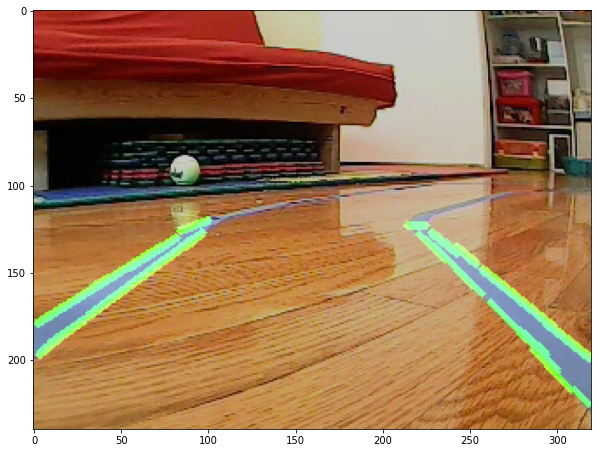

In [41]:
# rgb이미지에 허프변환한 라인들을 그려서 만든 이미지 완성하기
plt.figure(figsize=(10,8))
plt.imshow(display_lines(rgb_frame,lines))

In [43]:
###
# 사용자정의함수: igx_display_lines
#  - 본원이미지 소스에 허프변환으로 탐지된 Lines들을 결합해서 이미지 생성
### 
def igx_display_lines(source_image,lines):
    rgb_frame_with_lines = source_image.copy()
    for i in range(lines.shape[0]):
        x1,y1,x2,y2 = lines[i][0]
        print("%s,%s,%s,%s -> %5.1f"%(x1,y1,x2,y2,length_of_line_segment((x1,y1,x2,y2))))
        cv2.line(rgb_frame_with_lines,(x1,y1),(x2,y2),(0,255,0),2)
    return rgb_frame_with_lines

In [44]:
comb_rgb_image = igx_display_lines(rgb_frame,lines)

2,179,73,135 ->  83.5
242,135,254,145 ->  15.6
295,204,308,217 ->  18.4
225,131,236,142 ->  15.6
228,127,243,139 ->  19.2
277,164,299,182 ->  28.4
31,175,91,131 ->  74.4
286,191,300,205 ->  19.8
287,194,300,207 ->  18.4
262,167,276,181 ->  19.8
55,147,82,130 ->  31.9
257,148,276,163 ->  24.2
3,197,17,185 ->  18.4
310,217,318,225 ->  11.3
221,128,235,142 ->  19.8
243,149,251,157 ->  11.3
293,178,319,199 ->  33.4
287,195,299,207 ->  17.0
33,159,43,153 ->  11.7
214,123,225,123 ->  11.0
230,135,257,162 ->  38.2
87,135,97,127 ->  12.8
9,191,29,177 ->  24.4
278,183,294,197 ->  21.3
84,126,100,120 ->  17.1


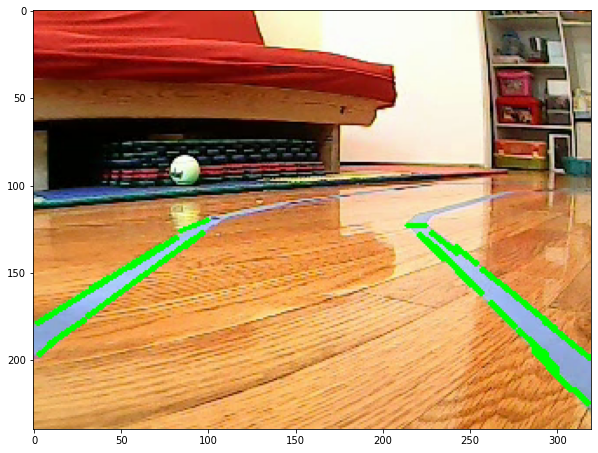

In [45]:
plt.figure(figsize=(10,8))
_ = plt.imshow(comb_rgb_image)

### 3> 라인의 경사와 절편 구하기

In [46]:
lines.shape[0]

25

In [47]:
for i in range(lines.shape[0]):
    x1,y1,x2,y2 = lines[i][0]
    fit = np.polyfit((x1, x2), (y1, y2), 1)
    slope = fit[0]
    intercept=fit[1]
    print("%s,%s,%s,%s\t-> %5.1f,\tslope= %f, intercept=%f"%(x1,y1,x2,y2,length_of_line_segment((x1,y1,x2,y2)),slope,intercept))


2,179,73,135	->  83.5,	slope= -0.619718, intercept=180.239437
242,135,254,145	->  15.6,	slope= 0.833333, intercept=-66.666667
295,204,308,217	->  18.4,	slope= 1.000000, intercept=-91.000000
225,131,236,142	->  15.6,	slope= 1.000000, intercept=-94.000000
228,127,243,139	->  19.2,	slope= 0.800000, intercept=-55.400000
277,164,299,182	->  28.4,	slope= 0.818182, intercept=-62.636364
31,175,91,131	->  74.4,	slope= -0.733333, intercept=197.733333
286,191,300,205	->  19.8,	slope= 1.000000, intercept=-95.000000
287,194,300,207	->  18.4,	slope= 1.000000, intercept=-93.000000
262,167,276,181	->  19.8,	slope= 1.000000, intercept=-95.000000
55,147,82,130	->  31.9,	slope= -0.629630, intercept=181.629630
257,148,276,163	->  24.2,	slope= 0.789474, intercept=-54.894737
3,197,17,185	->  18.4,	slope= -0.857143, intercept=199.571429
310,217,318,225	->  11.3,	slope= 1.000000, intercept=-93.000000
221,128,235,142	->  19.8,	slope= 1.000000, intercept=-93.000000
243,149,251,157	->  11.3,	slope= 1.000000, int

### 4> 허프변환의 여러 라인을 좌/우 1개씩으로 병합하기(평균화하기)

We can see from the picture above that all line segments belonging to the left lane line should be upward sloping and on the left side of the screen, whereas all line segments belonging to the right lane line should be downward sloping and be on the right side of the screen. 

* 오늘쪽 차선 -> Upward sloping/스크린의 왼쪽
* 왼쪽 차선 -> downward sloping/오른쪽에 위치 
* 중심을 기준으로 어디에 있는지 파악하고, 슬로프의 방향을 파악하는 것이 유효

![이미지 슬로우 계산 및 병합하기](https://api.monosnap.com/file/download?id=LdthBuT417fOTRagrUFIaDsLRCbbOT)

In [48]:
###
# 평균경사와 절편을 입력으로 사용해서 이미지내의 라인의 좌표값 설정하기(4개 ->x1,y1,x2,y2)
###
def make_points(frame, line):
    # 라인이 그려질 이미지의 높이와 넓이 픽셀값을 추출
    height, width, _ = frame.shape  # 프레임이 컬러인 경우, channel값이 반환(여기서는 _으로 사용)
    slope, intercept = line

    # (설명) 높이의 경우, 원래이미지의 1/2높이가 최대 라인의 높이, 바닦은 높이값으로 설정
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down


    print("y1,y2=>",y1,y2)
    print("x1->",-width, min(2 * width, int((y1 - intercept) / slope)))
    print("x2->",-width, min(2 * width, int((y2 - intercept) / slope)))
    # 높이값을 기준으로해서 x1,x2값을 계산
    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

In [49]:
###
# 허프변환의 결과들로 얻어진 선들로부터 왼쪽/오른쪽읜 평균 경사와 절편값 구하기
###
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    # 화면을 3분등해서 왼쪽/오른쪽 영역을 구분
    # 화면의 왼쪽 2/3은 왼쪽, 화면의 오른쪽 2/3은 오른쪽
    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    # 라인이 왼쪽인지, 오른쪽인 구분
    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue

            # 점값을 사용해서 경사도 구하기/절편 구하기
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if abs(slope) > 0.25:
                if slope < 0:  # 경사도가 0보다 작다면(내려간다면)
                    if x1 < left_region_boundary and x2 < left_region_boundary:
                        left_fit.append((slope, intercept))
                else: # 경사도가 0보다 크다면 (올라간다면)
                    if x1 > right_region_boundary and x2 > right_region_boundary:
                        right_fit.append((slope, intercept))

    print("len(left_fit,right_fit)=",len(left_fit),len(right_fit))

    left_fit_average = None
    right_fit_average = None
    if len(left_fit) > 0:
        left_fit_average = np.average(left_fit, axis=0)
        lane_lines.append(make_points(frame, left_fit_average))

    if len(right_fit) > 0:
        right_fit_average = np.average(right_fit, axis=0)
        lane_lines.append(make_points(frame, right_fit_average))

    print("슬로프와 절편 평균값(왼쪽,오른쪽) ",left_fit_average,"->",right_fit_average)
    logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines

### 5> 주행선 평균라인 그리기

In [50]:
# 허프변환으로 생성된 여러라인들로부터 왼쪽, 오른쪽의 대표 라인을 위한 평균 라인 좌표를 출력
avg_lane_lines = average_slope_intercept(rgb_frame.copy(), lines)
avg_lane_lines

len(left_fit,right_fit)= 8 16
y1,y2=> 240 120
x1-> -320 -79
x2-> -320 101
y1,y2=> 240 120
x1-> -320 343
x2-> -320 215
슬로프와 절편 평균값(왼쪽,오른쪽)  [ -0.66435302 187.17172852] -> [  0.93273007 -80.84385083]


[[[-79, 240, 101, 120]], [[343, 240, 215, 120]]]

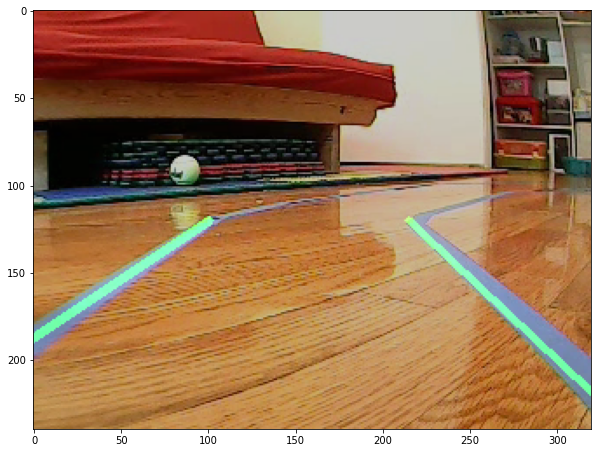

In [51]:
# rgb이미지에 허프변환한 라인들을 그려서 만든 이미지 완성하기
plt.figure(figsize=(10,8))
avg_lane_lines_image = display_lines(rgb_frame.copy(), avg_lane_lines)
plt.imshow(avg_lane_lines_image)

## [7] 중앙선 탐지 - 주행계획수립(Motion Planning)

In [52]:
###
# 주행을 위한 각도를 계산하기(중앙선 계산)
###

def compute_steering_angle(frame, lane_lines):
    """ Find the steering angle based on lane line coordinate
        We assume that camera is calibrated to point to dead center
    """
    if len(lane_lines) == 0:
        logging.info('No lane lines detected, do nothing')
        return -90

    height, width, _ = frame.shape
    if len(lane_lines) == 1:
        logging.debug('Only detected one lane line, just follow it. %s' % lane_lines[0])
        x1, _, x2, _ = lane_lines[0][0]
        x_offset = x2 - x1
    else:
        _, _, left_x2, _ = lane_lines[0][0]
        _, _, right_x2, _ = lane_lines[1][0]
        camera_mid_offset_percent = 0.02 # 0.0 means car pointing to center, -0.03: car is centered to left, +0.03 means car pointing to right
        mid = int(width / 2 * (1 + camera_mid_offset_percent))
        x_offset = (left_x2 + right_x2) / 2 - mid

    # find the steering angle, which is angle between navigation direction to end of center line
    y_offset = int(height / 2)

    # 중앙 수직선에 대한 각도(radian) angle (in radian) to center vertical line
    angle_to_mid_radian = math.atan(x_offset / y_offset)  
    
    # 중앙 수직선에 대한 각도 (angle) angle (in degrees) to center vertical line
    angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi)  
    
    # 중악 수직선에 대한 주행각도 this is the steering angle needed by picar front wheel
    steering_angle = angle_to_mid_deg + 90  

    print("각도(radian),각도, 주행각도=",angle_to_mid_radian, angle_to_mid_deg, steering_angle)

    logging.debug('new steering angle: %s' % steering_angle)
    return steering_angle

In [53]:
steering_angle = compute_steering_angle(avg_lane_lines_image, avg_lane_lines)
steering_angle

각도(radian),각도, 주행각도= -0.04164257909858842 -2 88


88

### 주행선의 Heading(운전할때 기준)선 그리기

In [54]:
def display_heading_line(frame, steering_angle, line_color=(255, 0, 0), line_width=5, ):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right 
    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return heading_image

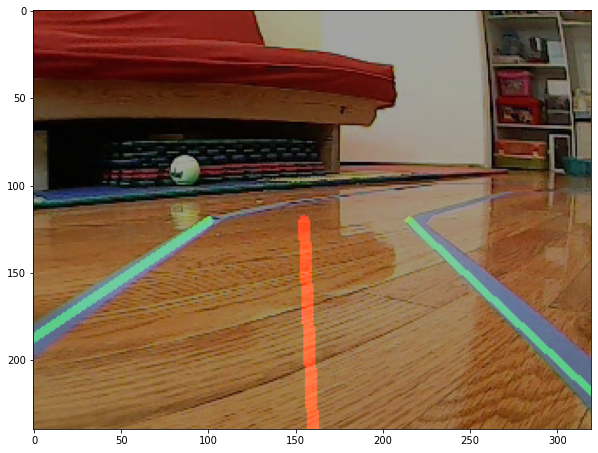

In [55]:
plt.figure(figsize=(10,8))
_ = plt.imshow(display_heading_line(avg_lane_lines_image,steering_angle))

## [8] 주행선 하나가 탐지된 경우의 처리

### 1> 이미지 로딩

In [56]:
single_frame = cv2.imread('/content/DeepPiCar/driver/data/road3_240x320.png')

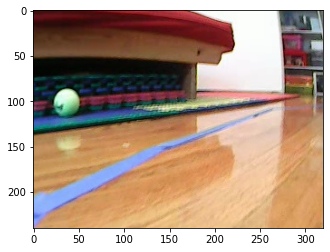

In [57]:
rgb_single_frame = cv2.cvtColor(single_frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_single_frame)

### 2> HSV이미지 변환 및 HSV기반 마스크필터 설정 

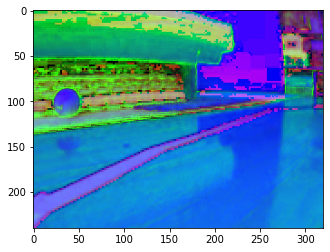

In [58]:
hsv_single_image = cv2.cvtColor(single_frame, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_single_image)

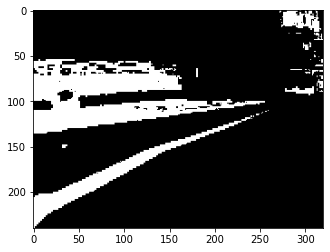

In [59]:
# 하한값과 상한값 사이의 픽셀에는 255, 나머지는 0으로 설정
single_mask = cv2.inRange(hsv_single_image, lower_blue, upper_blue)
plt.imshow(single_mask,cmap='gray')

### 3> Edge탐지하기

In [60]:
single_edges = cv2.Canny(single_mask, 200, 400)

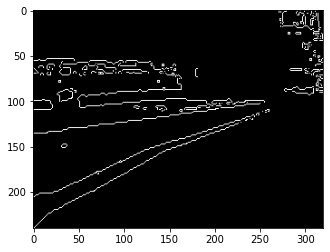

In [61]:
plt.imshow(single_edges,cmap='gray')

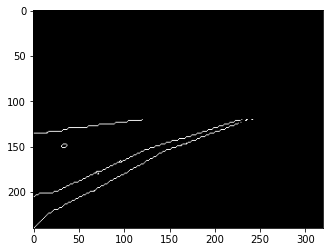

In [62]:
cropped_single_edges = cv2.bitwise_and(single_edges, bg_mask)
plt.imshow(cropped_single_edges,cmap="gray")

### 4> 허프변환사용하기(라인성분 추출하기)

In [63]:
single_lines = detect_line_segments(cropped_single_edges)
single_lines.shape[0]

detected line_segment:
[[151 153 235 121]] of length 89.89
detected line_segment:
[[ 81 173 135 149]] of length 59.09
detected line_segment:
[[ 95 183 148 153]] of length 60.90
detected line_segment:
[[159 143 181 135]] of length 23.41
detected line_segment:
[[ 79 125  90 124]] of length 11.05
detected line_segment:
[[ 19 201 113 159]] of length 102.96
detected line_segment:
[[ 39 129  59 129]] of length 20.00
detected line_segment:
[[136 149 162 141]] of length 27.20
detected line_segment:
[[214 125 224 121]] of length 10.77
detected line_segment:
[[ 66 199 115 171]] of length 56.44
detected line_segment:
[[  0 135   8 135]] of length  8.00
detected line_segment:
[[ 26 219  63 199]] of length 42.06
detected line_segment:
[[149 153 165 147]] of length 17.09
detected line_segment:
[[190 133 204 128]] of length 14.87
detected line_segment:
[[ 17 133  25 133]] of length  8.00
detected line_segment:
[[ 14 226  47 207]] of length 38.08
detected line_segment:
[[186 134 199 129]] of length 13

20

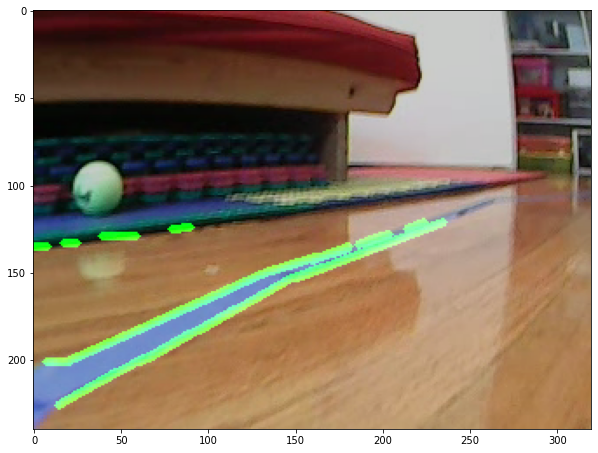

In [64]:
# rgb이미지에 허프변환한 라인들을 그려서 만든 이미지 완성하기
plt.figure(figsize=(10,8))
plt.imshow(display_lines(rgb_single_frame,single_lines))

### 5> 라인의 경사와 절편구하기

* 라인이 아닌 성분을 어떻게 삭제할 것인가 ?
    * 기울기인가? 흠..



In [65]:
for i in range(single_lines.shape[0]):
    x1,y1,x2,y2 = single_lines[i][0]
    fit = np.polyfit((x1, x2), (y1, y2), 1)
    slope = fit[0]
    intercept=fit[1]
    print("%s,%s,%s,%s\t-> %5.1f,\tslope= %f, intercept=%f"%(x1,y1,x2,y2,length_of_line_segment((x1,y1,x2,y2)),slope,intercept))

151,153,235,121	->  89.9,	slope= -0.380952, intercept=210.523810
81,173,135,149	->  59.1,	slope= -0.444444, intercept=209.000000
95,183,148,153	->  60.9,	slope= -0.566038, intercept=236.773585
159,143,181,135	->  23.4,	slope= -0.363636, intercept=200.818182
79,125,90,124	->  11.0,	slope= -0.090909, intercept=132.181818
19,201,113,159	-> 103.0,	slope= -0.446809, intercept=209.489362
39,129,59,129	->  20.0,	slope= 0.000000, intercept=129.000000
136,149,162,141	->  27.2,	slope= -0.307692, intercept=190.846154
214,125,224,121	->  10.8,	slope= -0.400000, intercept=210.600000
66,199,115,171	->  56.4,	slope= -0.571429, intercept=236.714286
0,135,8,135	->   8.0,	slope= -0.000000, intercept=135.000000
26,219,63,199	->  42.1,	slope= -0.540541, intercept=233.054054
149,153,165,147	->  17.1,	slope= -0.375000, intercept=208.875000
190,133,204,128	->  14.9,	slope= -0.357143, intercept=200.857143
17,133,25,133	->   8.0,	slope= -0.000000, intercept=133.000000
14,226,47,207	->  38.1,	slope= -0.575758, 

### 6> 주행선 평균라인 그리기

In [66]:
len(single_lines)

20

In [67]:
# 허프변환으로 생성된 여러라인들로부터 왼쪽, 오른쪽의 대표 라인을 위한 평균 라인 좌표를 출력
avg_single_lane_lines = average_slope_intercept(rgb_single_frame.copy(), single_lines)
avg_single_lane_lines

len(left_fit,right_fit)= 13 0
y1,y2=> 240 120
x1-> -320 -53
x2-> -320 211
슬로프와 절편 평균값(왼쪽,오른쪽)  [ -0.45227176 215.79876733] -> None


[[[-53, 240, 211, 120]]]

### 7> rgb이미지와 주행선 평균선 그리기

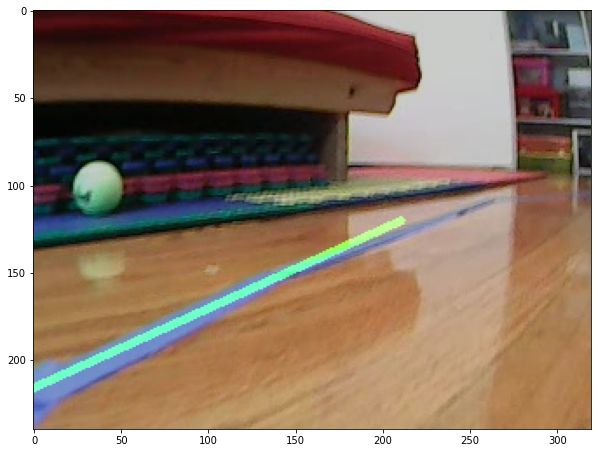

In [68]:
# rgb이미지에 허프변환한 라인들을 그려서 만든 이미지 완성하기
plt.figure(figsize=(10,8))
avg_single_lane_lines_image = display_lines(rgb_single_frame.copy(), avg_single_lane_lines)
plt.imshow(avg_single_lane_lines_image)

### 8> 주행선의 heading line 그리기

In [69]:
len(avg_single_lane_lines)

1

In [70]:
single_steering_angle = compute_steering_angle(avg_single_lane_lines_image, avg_single_lane_lines)
single_steering_angle

각도(radian),각도, 주행각도= 1.1441688336680205 65 155


155

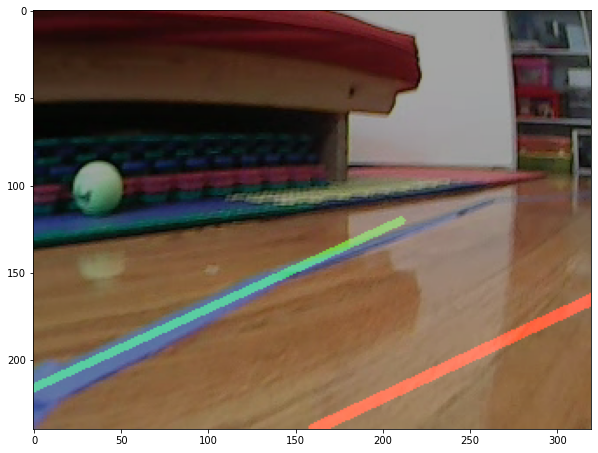

In [71]:
plt.figure(figsize=(10,8))
_ = plt.imshow(display_heading_line(avg_single_lane_lines_image,single_steering_angle))

## [9] 안정화(Stabilization)

*   현재 영상의 입력은 1프레임씩 받아서 처리하기 때문에, 프레임마다 이산적 값으로 변동하면 움직임이 큼
    * 예를 들어서, 120도에서 70도로 변경도 될 수 있음
    * 현재는 90도를 기준으로 하여 값이 변동되도록 계산하였음 (90+스티어링 각도 덧셈식)
*  이에 연속적으로 값이 변동되도록 변경이 필요
    * 예를 들어서, 90,91,92....로 자연스럽게 각도를 변경하는 것이 바람직
* 해결책으로 max_angle_deviation을 사용
    * 각도 변화가 급격하면 새로운 각도에 max_angle_deviation만큼을 반영
    * 두개의 주행선의 경우, 5도 변경가능
    * 1개의 주행선의 경우, 1도 변경 가능





In [72]:
def stabilize_steering_angle(
          curr_steering_angle, 
          new_steering_angle, 
          num_of_lane_lines, 
          max_angle_deviation_two_lines=5, 
          max_angle_deviation_one_lane=1):
    """
    Using last steering angle to stabilize the steering angle
    if new angle is too different from current angle, 
    only turn by max_angle_deviation degrees
    """
    if num_of_lane_lines == 2 :
        # if both lane lines detected, then we can deviate more
        max_angle_deviation = max_angle_deviation_two_lines
    else :
        # if only one lane detected, don't deviate too much
        max_angle_deviation = max_angle_deviation_one_lane
    
    angle_deviation = new_steering_angle - curr_steering_angle
    print(angle_deviation)

    if abs(angle_deviation) > max_angle_deviation:
        stabilized_steering_angle = int(curr_steering_angle
            + max_angle_deviation * angle_deviation / abs(angle_deviation))
    else:
        stabilized_steering_angle = new_steering_angle
    return stabilized_steering_angle

In [73]:
# 변경한 각도 차이가 크기 나와도 조금만 변경되도록 계산수행
stabilize_steering_angle(90,120,2)

30


95